## 04. Graph coded frames

In [49]:

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches



In [50]:
scale = 1/200.0
TRsamples = 130104
codedFramesRootPath = "/user/fsainz/data/out/coded/"
frameLength = "5"  # sec 



In [51]:
#frame2graph = "2018/01/03/11/37/38-41858570"
#frame2graph = "2018/01/03/11/41/56-42116913"
#frame2graph = "2018/01/22/17/7-63487655"
#frame2graph =   "/2018/01/22/20/42-75582521"  # 105-dat
#frame2graph =   "2018/01/22/22/50-82250290"   # 106-dat

In [52]:
dataOrg = "222"

frame2graph = dataOrg 
labeledPath= "/user/fsainz/data/input/labeled/"
labeledFrames = labeledPath + dataOrg + "-" + str(frameLength) + "s.not"
filesPath = codedFramesRootPath + frame2graph

In [53]:
print("validating: " + filesPath , "with " + labeledFrames)

validating: /user/fsainz/data/out/coded/222 with /user/fsainz/data/input/labeled/222-5s.not


## Read labeled files

In [55]:
labelsRdd = sc.textFile(labeledFrames).map(lambda x: x.split(',')).map(lambda x: (int(x[0]), x[1]))
labelsRdd.count()



362

## Read coded

In [58]:
eventsStrRdd = sc.textFile(filesPath)

In [59]:

e = eventsStrRdd.first()
eventsStrRdd.count()

361

In [60]:
def getFields( line ):
    line = line[1:-1]  # get rid of parenthesis
    line = line.split(';')
    #ret = ret.split(',')
    srcFrame =  list(map(  lambda x: float(x) , line[1].split(',')))
    codedFrame =list(map( lambda x: float(x) , line[2].split(',')))
    lossFrame = list(map( lambda x: float(x) , line[3].split(',')))
    ret = line[0].split(',')
    ret = ret[:-1]
    ret.extend([srcFrame,codedFrame,lossFrame])
    ret[1] = float(ret[1])
    ret[2] = int(float(ret[2]))
    ret[3] = float(ret[3])
    ret[0], ret[2] = ret[2],ret[0]
    return ret
    # return (ret, srcFrame, codedFrame, lossFrame)

In [61]:
codedframesRdd = eventsStrRdd.map( lambda x: getFields(x)   ).map( lambda x: (x[0],x[1:]))
codedframesRdd.count()

361

### join label and coded frames

In [62]:
codedlabeledRdd= codedframesRdd.join(labelsRdd).map( lambda x: (x[1][0][1], x[0], x[1][1], x[1][0][4],x[1][0][5],x[1][0][6] ))

### gert rid of trainingSet  And split rest  randomly into validation and test

In [63]:
print(TRsamples)
# TRaining frames are those we made the dictionary with
TRcodlabelsRdd = codedlabeledRdd.filter(lambda x: x[1]<= TRsamples)


RESTcodlabelsRdd =  codedlabeledRdd.filter(lambda x: x[1] > TRsamples)

TRcodlabels = TRcodlabelsRdd.collect()
RESTcodlabels = RESTcodlabelsRdd.collect()

import random
random.shuffle(RESTcodlabels)

valitationPercent = .4
splitpoint = int(len(RESTcodlabels) * valitationPercent)

Valcodlabels = RESTcodlabels[:splitpoint]
Tstcodlabels = RESTcodlabels[splitpoint:]
#TstcodlabelsRdd.take(2)[1]

130104


## Trigger selecction (offline)

In [64]:
def computeAbsErrors( labeledSamples, trigger, show=False):
   
    LabelPos,LabelNeg,TotalError, FalsePos,FalseNeg = 0,0,0,0,0

    for item in labeledSamples:
        if item[2] != "N":    # "labeled as anomaly"
            LabelPos += 1
            if np.max(np.abs(item[5])) < trigger : # Detected as normal
                TotalError += 1
                FalseNeg += 1
        else: 
            LabelNeg +=1      # Labeled as Normal"
            if np.max(np.abs(item[5])) >= trigger:  # detected as anomaly
                TotalError += 1
                FalsePos += 1

    n = LabelPos +LabelNeg
    ret = ( n, LabelPos, LabelNeg, trigger, 100 * TotalError/n, 100*FalsePos/n, 100*FalseNeg/n)
    if show:
        print( " Total Error: %d  pos:%d neg:%d  thes:%0.2f Total%%:%0.2f  FPos%%: %0.2f FNeg%%: %0.2f"%ret)
    return ret


### Use validation set two get threshold

In [65]:
trigger = 0.0
step = 0.0025
steps = 500
TotalError= []
FalsePos  = []
FalseNeg  = []
Triggers  = []
for t in range(steps):
    e = computeAbsErrors( Valcodlabels, trigger)
    Triggers.append(e[3])
    TotalError.append(e[4])
    FalsePos.append(e[5])
    FalseNeg.append(e[6])
    
    trigger += step

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['curier'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


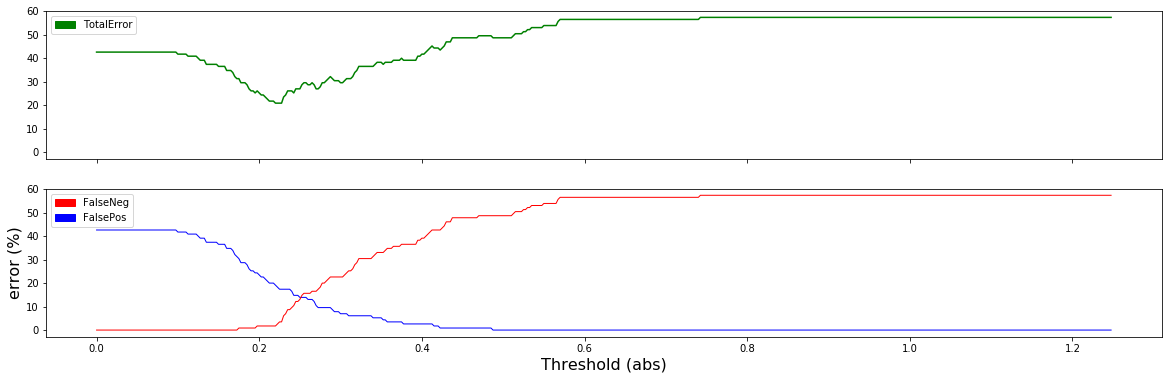

In [66]:
x = Triggers


tfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }

lfont = {'family': 'curier',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

fig, ax = plt.subplots(2,1,sharey=True, sharex=True,figsize=(20,6))

ax[0].plot(x, TotalError,"green")

plt.ylabel('error(%)',lfont)

ax[1].plot(x, FalsePos, 'blue', linewidth=1)
ax[1].plot(x, FalseNeg, 'red', linewidth=1)

green_patch = mpatches.Patch(color='green', label='TotalError')
blue_patch = mpatches.Patch(color='blue', label='FalsePos')
red_patch = mpatches.Patch(color='red', label='FalseNeg')


ax[0].legend(handles=[green_patch] )

ax[1].legend(handles=[red_patch, blue_patch] )
plt.xlabel('Threshold (abs)',lfont)
plt.ylabel('error (%)')

display(fig)
plt.close()

## Validation set error

In [67]:
MinError = np.min(TotalError)
idx = TotalError.index(MinError)
t = Triggers[idx]
print("Min error", MinError ,"@ theshold", t)

computeAbsErrors(Valcodlabels, t, True)

Min error 20.8695652174 @ theshold 0.22000000000000014
 Total Error: 115  pos:66 neg:49  thes:0.22 Total%:20.87  FPos%: 19.13 FNeg%: 1.74


(115,
 66,
 49,
 0.22000000000000014,
 20.869565217391305,
 19.130434782608695,
 1.7391304347826086)

## Test Error

In [68]:
computeAbsErrors(Tstcodlabels, t, True)

 Total Error: 173  pos:98 neg:75  thes:0.22 Total%:29.48  FPos%: 25.43 FNeg%: 4.05


(173,
 98,
 75,
 0.22000000000000014,
 29.479768786127167,
 25.433526011560694,
 4.046242774566474)

In [69]:
t

0.22000000000000014

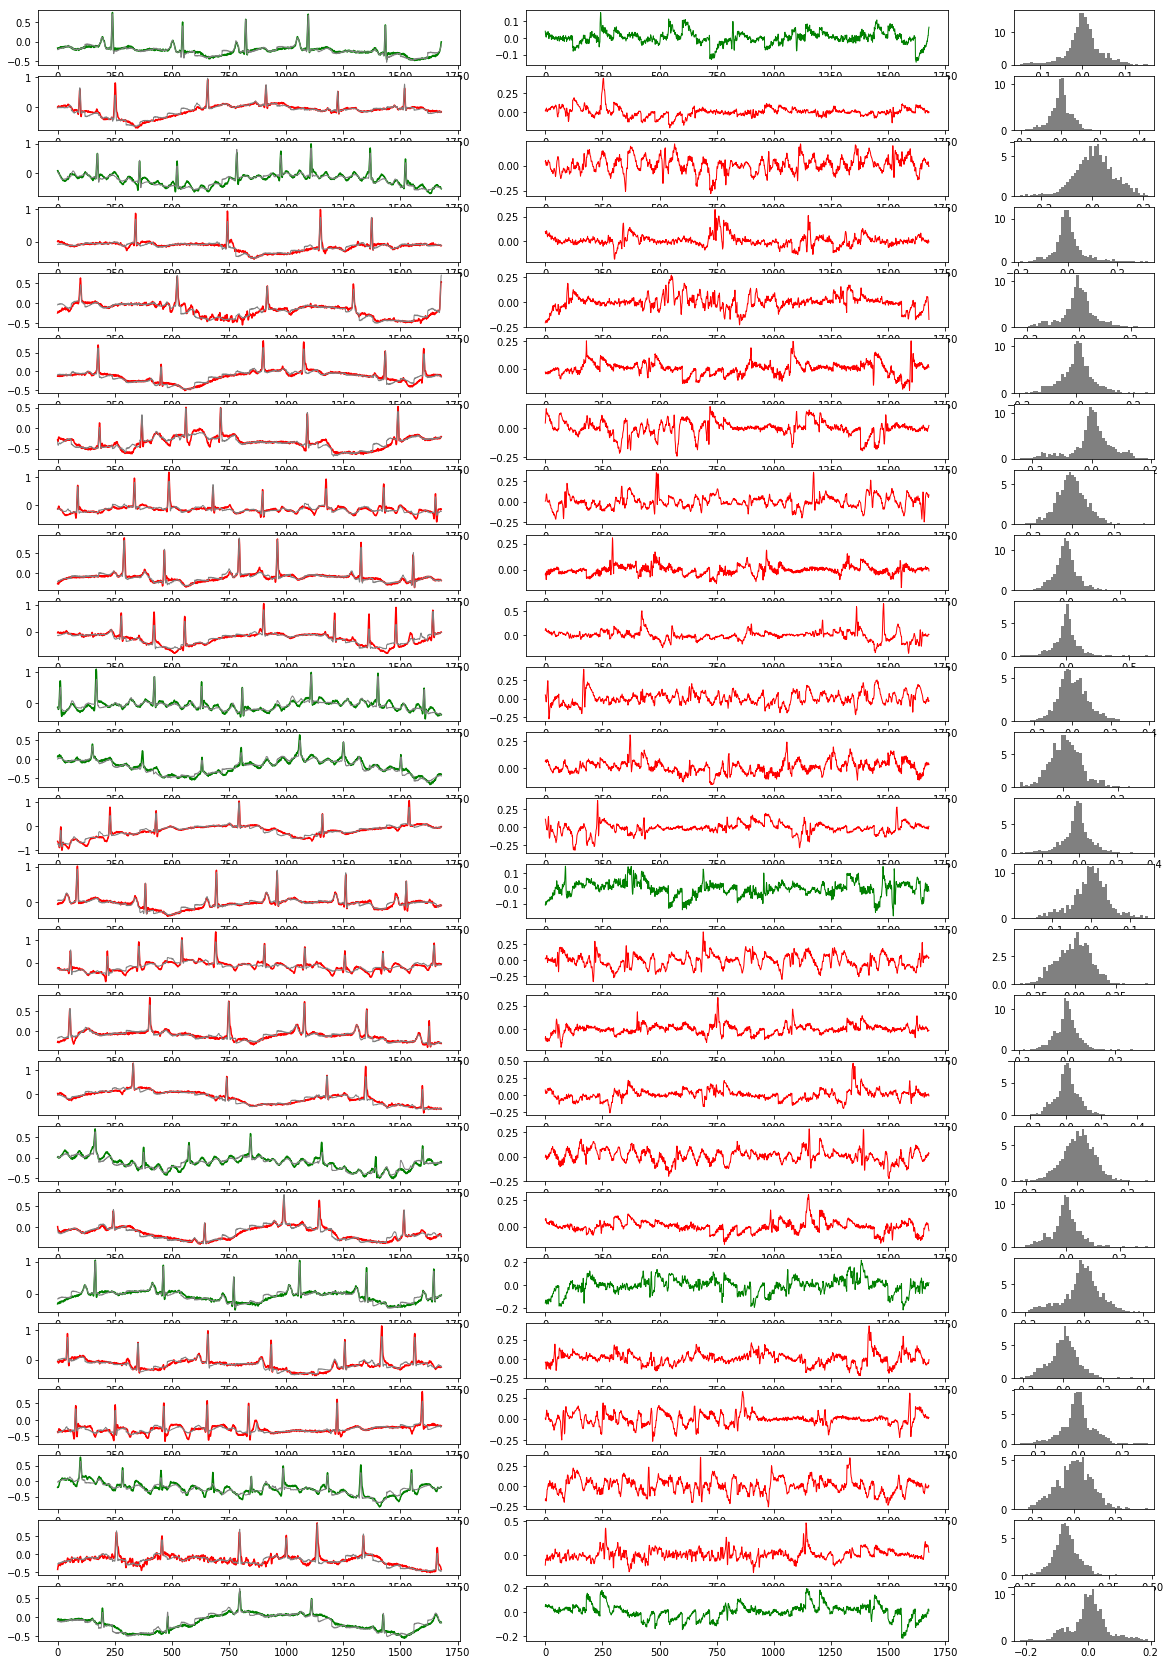

In [73]:
trigger = t
maxItemsDisplay = 25
l = len(Tstcodlabels[1][3])
x = range(00,l)
middle = 1024 * scale
samples = Tstcodlabels   ##.filter(lambda x: x[1]=='N').takeSample(False, maxItemsDisplay)

nsamples = min(len(samples), maxItemsDisplay)

fig, ax = plt.subplots(nsamples,3,figsize=(20,30), gridspec_kw = {'width_ratios':[3,3, 1]})
for idx, item in  enumerate( samples[:nsamples]):
    if item[2] != "N":
        labelColor = "Red"
    else:
        labelColor = "green"
    e = np.max(np.abs(item[5] ))
   
    if e >= trigger:
        lossColor = "Red"
    else:
        lossColor = "green"
        
    ax[idx][0].plot(x, np.array(item[3])-middle, labelColor)
    ax[idx][0].plot(x, np.array(item[4])-middle, 'gray', linewidth=1)
    ax[idx][1].plot(x, item[5], lossColor, linewidth=1)
   # the histogram of the data
    j, bins, patches = ax[idx][2].hist( item[5], 50, normed=1, facecolor='gray')

    
display(fig)
plt.close()


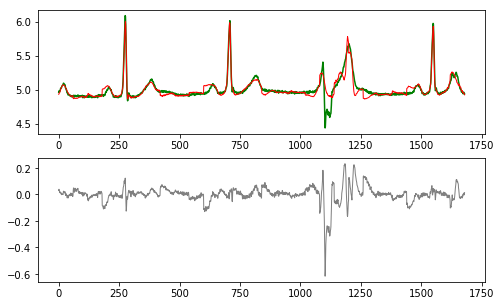

In [44]:
item = 24
l = len(samples[item][5])
x = range(00,l)

fig, ax = plt.subplots(2,1,figsize=(8,5))

ax[0].plot(x, samples[item][3],"green")
ax[0].plot(x, samples[item][4], 'red', linewidth=1)
ax[1].plot(x, samples[item][5], 'gray', linewidth=1)
#j, bins, patches = ax[2].hist( samples[item][5],50, normed=1, facecolor='blue')
#ax[2].plot(0,-1)
display(fig)
plt.close()

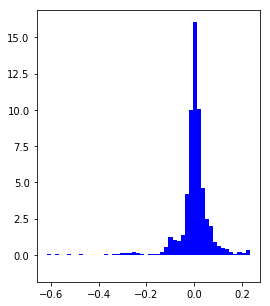

In [48]:
item = 24
l = len(samples[item][5])
x = range(00,l)

fig, ax = plt.subplots(1,1,figsize=(4,5))


j, bins, patches = ax.hist( samples[item][5],50, normed=1, facecolor='blue')
ax.plot(0,-1)
display(fig)
plt.close()

###
# Graph coded frames RDD

In [ ]:
item=4
nsamples = codedframesRdd.count()
samples = codedframesRdd.take(10)


In [ ]:
samples[item][1][4]

In [ ]:
print(samples[item][0], np.max(samples[item][1][4]),  np.max(samples[item][1][5]),  np.max(samples[item][1][6] ))

In [ ]:

l = len(samples[item][1][5])
x = range(00,l)

fig, ax = plt.subplots(3,1, sharex=True,figsize=(20,6))

ax[0].plot(x, samples[item][1][4],"green")
ax[0].plot(x, samples[item][1][5], 'gray', linewidth=1)
ax[2].plot(x, samples[item][1][6], 'gray', linewidth=1)
display(fig)
plt.close()

In [ ]:
x1,x2 = 1,360
l = len(samples[item][1][5][x1:x2])
x = range(00,l)

fig, ax = plt.subplots(3,1, sharex=True,figsize=(20,6))

ax[0].plot(x, samples[item][1][4][x1:x2],"green")
ax[0].plot(x, samples[item][1][5][x1:x2], 'gray', linewidth=1)
ax[2].plot(x, samples[item][1][6][x1:x2], 'gray', linewidth=1)
display(fig)
plt.close()

In [ ]:
plt.close('all') 

In [ ]:
maxItemsDisplay = 20
samples = codedframesRdd.takeSample(False, maxItemsDisplay)

l = len(samples[item][1][5])
x = range(00,l)



maxItemsDisplay
nsamples = min(codedframesRdd.count(), maxItemsDisplay)

fig, ax = plt.subplots(nsamples,3,figsize=(20,20), gridspec_kw = {'width_ratios':[3,3, 1]})
for idx, item in  enumerate( samples):
    labelColor = "green"  
    lossColor = "green"
    ax[idx][0].plot(x, item[1][4], labelColor)
    ax[idx][0].plot(x, item[1][5], 'gray', linewidth=1)
    ax[idx][1].plot(x, item[1][6], lossColor, linewidth=1)
   # the histogram of the data
    j, bins, patches = ax[idx][2].hist( item[1][4], 50, normed=1, facecolor='gray')
                                                                                        
    
display(fig)

In [ ]:
samples[item][1][5]

In [ ]:
item